# Homework 2 - Structural bioinformatics

Download the assigned PDB structure and consider only standard (non-hetero) residues of the specified chain. Calculate the contact map (question 5) and the conformational energy (questions 6 and 7) as described in the IUPRED paper. The M and P matrices are available from the iupred_data.py. The smoothed energy is the moving average of the raw energy over a window of 21 residues (±10 residues around the current position).


In [21]:
!pip install biopython
!pip install scipy
!pip install matplotlib


[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: C:\Users\Marco\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: C:\Users\Marco\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: C:\Users\Marco\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [22]:
from Bio.PDB import PDBList, is_aa, PDBIO
from Bio.PDB.PDBParser import PDBParser
from Bio.SeqUtils import IUPACData
from Bio.PDB.PDBIO import Select
from Bio.SeqIO.PdbIO import PdbSeqresIterator
from Bio.PDB import NeighborSearch
import numpy as np
import copy
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import scipy.signal
from matplotlib import colors
from Bio.SeqUtils import seq1

In [23]:
# Input
pdb_id = '1d9n'

In [24]:
PATH = "./pdb/"

In [25]:
# Fetch a PDB file from the website to the current dir
# Question: how do you download structures from the PDB?
pdbl = PDBList()
pdbl.retrieve_pdb_file(pdb_id, pdir=PATH, file_format='pdb') 

'./pdb/pdb1d9n.ent'

In [26]:
# Get the SEQRES using SeqIO
# It finds and parse all SEQRES fields inside a PDB file and create SeqRecord objects
with open(PATH + "/pdb{}.ent".format(pdb_id)) as f:
  seq_records = (PdbSeqresIterator(f))
  for seq_record in seq_records:
    print(seq_record)

# Print SeqRecord methods and attributes
print("\n".join([ele for ele in dir(seq_record) if ele[0] != '_']))

ID: 1D9N:A
Name: 1D9N:A
Description: UNP:Q9UIS9 MBD1_HUMAN
Database cross-references: UNP:Q9UIS9, UNP:MBD1_HUMAN
Number of features: 0
/chain=A
/molecule_type=protein
Seq('MAEDWLDCPALGPGWKRREVFRKSGATCGRSDTYYQSPTGDRIRSKVELTRYLG...APK')
annotations
count
dbxrefs
description
features
format
id
islower
isupper
letter_annotations
lower
name
reverse_complement
seq
translate
upper


In [39]:
# Start end positions of a domain identified in PDB 18bt
structure = PDBParser(QUIET=True).get_structure(pdb_id, PATH + "/pdb{}.ent".format(pdb_id))

domain_residues = []
start_flag = False

# Iterate residues of specific chain (A) and model (0)
for residue in structure[0]['A'].get_residues():  # Model 0, chain A
  if residue.id[0] == " ":
    # Exclude hetero and water atoms
      # print(residue.id)
      # Get starting position, a piori I don't know where is the first residue
      domain_residues.append(residue)
      #print(residue.id)

      # Get ending position

for residue in domain_residues:
  print(residue)

<Residue MET het=  resseq=1 icode= >
<Residue ALA het=  resseq=2 icode= >
<Residue GLU het=  resseq=3 icode= >
<Residue ASP het=  resseq=4 icode= >
<Residue TRP het=  resseq=5 icode= >
<Residue LEU het=  resseq=6 icode= >
<Residue ASP het=  resseq=7 icode= >
<Residue CYS het=  resseq=8 icode= >
<Residue PRO het=  resseq=9 icode= >
<Residue ALA het=  resseq=10 icode= >
<Residue LEU het=  resseq=11 icode= >
<Residue GLY het=  resseq=12 icode= >
<Residue PRO het=  resseq=13 icode= >
<Residue GLY het=  resseq=14 icode= >
<Residue TRP het=  resseq=15 icode= >
<Residue LYS het=  resseq=16 icode= >
<Residue ARG het=  resseq=17 icode= >
<Residue ARG het=  resseq=18 icode= >
<Residue GLU het=  resseq=19 icode= >
<Residue VAL het=  resseq=20 icode= >
<Residue PHE het=  resseq=21 icode= >
<Residue ARG het=  resseq=22 icode= >
<Residue LYS het=  resseq=23 icode= >
<Residue SER het=  resseq=24 icode= >
<Residue GLY het=  resseq=25 icode= >
<Residue ALA het=  resseq=26 icode= >
<Residue THR het=  re

In [28]:
class Select(Select):
    def __init__(self, chain_ids=None, residues=None):
        self.chain_ids = chain_ids
        self.residues = residues

    def accept_chain(self, chain):
        return self.chain_ids is None or chain.id in self.chain_ids

    def accept_residue(self, residue):
        return self.residues is None or residue in self.residues

    def accept_atom(self, atom):
        return not atom.is_disordered() or atom.get_altloc() == "A"

In [29]:
io = PDBIO()
io.set_structure(structure[0])
io.save(PATH + "/pdb{}.ent".format(pdb_id), select=Select("A", residues=domain_residues))

## Q1 
Calculate and plot the contact map of your chain. Use the NeighborSearch module and the search_all(3.5, level=”R”) method. Consider only contacts between positions with a sequence separation ≥ 2.

In [30]:
ns = NeighborSearch(list(structure[0]['A'].get_atoms()))
pairsResidues = ns.search_all(3.5, level='R')
print(len(pairsResidues))

265


In [31]:
def check_res_pairs(res1, res2, pairs):
    for pair in pairs:
        if (res1 == pair[0] and res2 == pair[1]) or (res1 == pair[1] and res2 == pair[0]):
            return True
    return False


In [32]:
def get_distance_matrix(residues, pairs):
  distances = []
  for residue1 in residues:
    row = []
    for residue2 in residues:
      if(check_res_pairs(residue1, residue2, pairs)):
        if abs(residue1.id[1] - residue2.id[1]) >= 2:
          row.append(residue1['CA'] - residue2['CA'])
        else:
          row.append(None)
      else:
        row.append(None)
    distances.append(row)
  return np.array(distances, dtype=float)

In [33]:
structure = PDBParser(QUIET=True).get_structure(pdb_id, PATH + "/pdb{}.ent".format(pdb_id))

# select chain A of first model (0) and exclude hetero and water groups
selected_residues = [residue for residue in structure[0]['A'] if residue.id[0] == " "]

distance_matrix = get_distance_matrix(selected_residues, pairsResidues)

In [34]:
print(len(list(structure[0]['A'].get_atoms())))

1183


In [35]:
import sys
np.set_printoptions(threshold=sys.maxsize)
print(distance_matrix)


[[        nan         nan         nan         nan         nan         nan
          nan         nan         nan         nan         nan         nan
          nan         nan         nan         nan         nan         nan
          nan         nan         nan         nan         nan         nan
          nan         nan         nan         nan         nan         nan
          nan         nan         nan         nan         nan         nan
          nan         nan         nan         nan         nan         nan
          nan         nan         nan         nan         nan         nan
          nan         nan         nan         nan         nan         nan
          nan         nan         nan         nan         nan         nan
          nan         nan         nan         nan         nan         nan
          nan         nan         nan         nan         nan         nan
          nan         nan         nan]
 [        nan         nan         nan         nan  7.28059769         nan

In [36]:
contact_map = (distance_matrix[:] > 0).astype(float)
print(contact_map)
print(sum(sum(riga) for riga in contact_map))

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0.]
 [0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0.

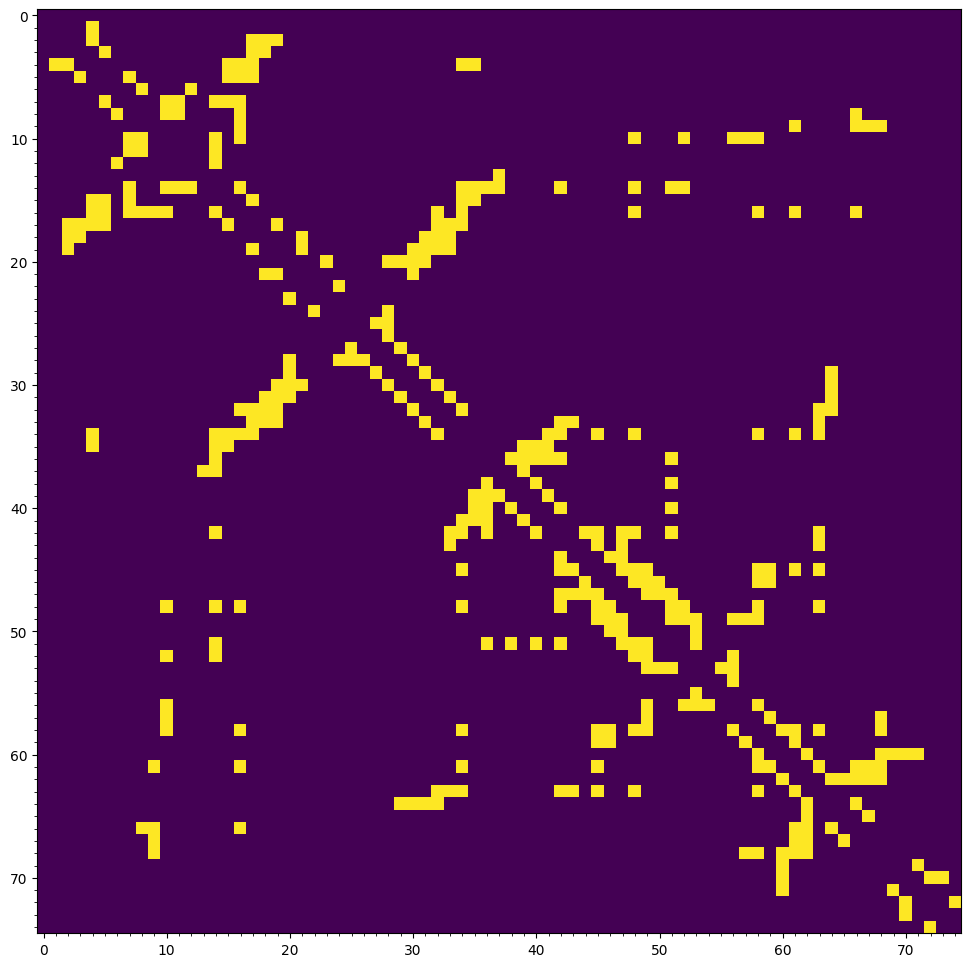

In [37]:
# Plot contact map
fig, ax = plt.subplots(figsize=(12, 12))
im = ax.imshow(contact_map)

# Set ticks
ax.xaxis.set_major_locator(MultipleLocator(10))
ax.xaxis.set_minor_locator(AutoMinorLocator(10))
ax.yaxis.set_major_locator(MultipleLocator(10))
ax.yaxis.set_minor_locator(AutoMinorLocator(10))

## Q2
Calculate the exact energy of each residue based on the weighted contribution of its contacts (as calculated above) and plot the raw and smoothed energy for each residue on the same figure. Use the M matrix to calculate the contact energy.

In [41]:
# import aa_list, p_matrix, m_matrix
execfile("iupred_data.py")

In [42]:
aa_list

['A',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'K',
 'L',
 'M',
 'N',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'V',
 'W',
 'Y']

In [43]:
m_matrix

[[-0.2,
  -0.44,
  0.16,
  0.26,
  -0.46,
  -0.26,
  0.5,
  -0.57,
  0.1,
  -0.36,
  -0.22,
  0.07,
  0.14,
  0.01,
  0.2,
  -0.09,
  -0.05,
  -0.42,
  0.05,
  -0.5],
 [-0.44,
  -2.99,
  0.21,
  0.19,
  -0.88,
  -0.34,
  -1.11,
  -0.36,
  0.09,
  -0.53,
  -0.43,
  -0.52,
  -0.14,
  -0.43,
  -0.24,
  0.13,
  -0.22,
  -0.62,
  0.24,
  -0.79],
 [0.16,
  0.21,
  0.17,
  0.55,
  0.38,
  0.35,
  -0.23,
  0.44,
  0.39,
  0.28,
  0.35,
  -0.02,
  1.03,
  0.49,
  -0.37,
  0.19,
  -0.12,
  0.69,
  0.04,
  0.43],
 [0.26,
  0.19,
  0.55,
  0.6,
  0.55,
  0.65,
  0.18,
  0.37,
  0.47,
  0.33,
  0.29,
  0.01,
  0.69,
  0.04,
  -0.52,
  0.18,
  0.37,
  0.39,
  0.03,
  0.17],
 [-0.46,
  -0.88,
  0.38,
  0.55,
  -0.94,
  0.17,
  -0.4,
  -0.88,
  0.01,
  -1.08,
  -0.78,
  0.22,
  0.2,
  0.26,
  -0.19,
  -0.22,
  0.02,
  -1.15,
  -0.6,
  -0.88],
 [-0.26,
  -0.34,
  0.35,
  0.65,
  0.17,
  -0.12,
  0.18,
  0.24,
  0.19,
  0.24,
  0.02,
  -0.04,
  0.6,
  0.46,
  0.5,
  0.28,
  0.28,
  0.27,
  0.51,
  -0.35

In [44]:
p_matrix

[[-1.65,
  -2.83,
  1.16,
  1.8,
  -3.73,
  -0.41,
  1.9,
  -3.69,
  0.49,
  -3.01,
  -2.08,
  0.66,
  1.54,
  1.2,
  0.98,
  -0.08,
  0.46,
  -2.31,
  0.32,
  -4.62],
 [-2.83,
  -39.58,
  -0.82,
  -0.53,
  -3.07,
  -2.96,
  -4.98,
  0.34,
  -1.38,
  -2.15,
  1.43,
  -4.18,
  -2.13,
  -2.91,
  -0.41,
  -2.33,
  -1.84,
  -0.16,
  4.26,
  -4.46],
 [1.16,
  -0.82,
  0.84,
  1.97,
  -0.92,
  0.88,
  -1.07,
  0.68,
  -1.93,
  0.23,
  0.61,
  0.32,
  3.31,
  2.67,
  -2.02,
  0.91,
  -0.65,
  0.94,
  -0.71,
  0.9],
 [1.8,
  -0.53,
  1.97,
  1.45,
  0.94,
  1.31,
  0.61,
  1.3,
  -2.51,
  1.14,
  2.53,
  0.2,
  1.44,
  0.1,
  -3.13,
  0.81,
  1.54,
  0.12,
  -1.07,
  1.29],
 [-3.73,
  -3.07,
  -0.92,
  0.94,
  -11.25,
  0.35,
  -3.57,
  -5.88,
  -0.82,
  -8.59,
  -5.34,
  0.73,
  0.32,
  0.77,
  -0.4,
  -2.22,
  0.11,
  -7.05,
  -7.09,
  -8.8],
 [-0.41,
  -2.96,
  0.88,
  1.31,
  0.35,
  -0.2,
  1.09,
  -0.65,
  -0.16,
  -0.55,
  -0.52,
  -0.32,
  2.25,
  1.11,
  0.84,
  0.71,
  0.59,
  -0.38,

FileNotFoundError: [Errno 2] No such file or directory: './img/iupred_matrix.png'

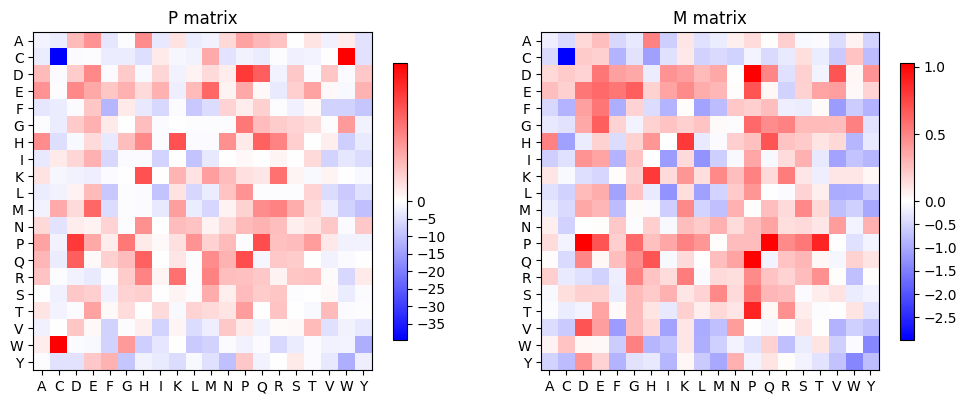

In [46]:
p_matrix = np.array(p_matrix)
m_matrix = np.array(m_matrix)

# Plot the M and P matrix
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
divnorm = colors.TwoSlopeNorm(vmin=np.amin(p_matrix), vcenter=0.,
                              vmax=np.amax(p_matrix))  # center the colormap (white) to 0
img = axes[0].imshow(p_matrix, interpolation="none", cmap='bwr', norm=divnorm)
axes[0].set_title('P matrix')
axes[0].set_xticks([i for i, aa in enumerate(aa_list)])
axes[0].set_xticklabels(aa_list)
axes[0].set_yticks([i for i, aa in enumerate(aa_list)])
axes[0].set_yticklabels(aa_list)
fig.colorbar(img, ax=axes[0], shrink=0.6)

divnorm = colors.TwoSlopeNorm(vmin=np.amin(m_matrix), vcenter=0.,
                              vmax=np.amax(m_matrix))  # center the colormap (white) to 0
img = axes[1].imshow(m_matrix, interpolation="none", cmap='bwr', norm=divnorm)
axes[1].set_title('M matrix')
axes[1].set_xticks([i for i, aa in enumerate(aa_list)])
axes[1].set_xticklabels(aa_list)
axes[1].set_yticks([i for i, aa in enumerate(aa_list)])
axes[1].set_yticklabels(aa_list)
fig.colorbar(img, ax=axes[1], shrink=0.6)

plt.savefig('./img/iupred_matrix.png', dpi=300, bbox_inches='tight')

In [ ]:
def interactions_residues(seq, contact_map):
    '''
    given a sequence and a contact map return a matrix with the number of interactions between all the amino acids
    '''
    interactions = np.zeros((20, 20))
    for i in range(len(seq)):
        for j in range(len(seq)):
            if contact_map[i][j] == 1:
                interactions[IUPACData.protein_letters.index(seq[i])][IUPACData.protein_letters.index(seq[j])] += 1
    return interactions

In [ ]:
print(interactions_residues(seq, contact_map))

[[ 0.  4.  1.  3.  1.  4.  2.  4.  9.  1.  0.  1.  0.  1.  2.  0.  0.  1.
   1.  7.]
 [ 4. 20.  0.  0.  3.  5.  6.  2. 16.  6.  0.  2.  0.  3.  3.  6.  1.  8.
   1.  6.]
 [ 1.  0.  2.  2.  0.  1.  1.  1.  2.  1.  0.  1.  0.  0.  0.  1.  0.  1.
   0.  0.]
 [ 3.  0.  2.  0.  3.  1.  3.  0.  6.  1.  1.  0.  0.  1.  0.  2.  2.  7.
   0.  2.]
 [ 1.  3.  0.  3.  2.  4.  2.  3.  5.  3.  0.  1.  0.  1.  0.  5.  0.  7.
   1.  1.]
 [ 4.  5.  1.  1.  4.  4.  0.  1.  9.  1.  0.  1.  2.  2.  2.  5.  0.  2.
   4.  4.]
 [ 2.  6.  1.  3.  2.  0.  0.  1.  2.  0.  0.  0.  1.  1.  0.  2.  0.  4.
   0.  3.]
 [ 4.  2.  1.  0.  3.  1.  1.  0.  3.  4.  1.  0.  0.  0.  1.  2.  0.  1.
   2.  0.]
 [ 9. 16.  2.  6.  5.  9.  2.  3.  2.  4.  1.  2.  1.  1.  1.  5.  2.  8.
   3.  9.]
 [ 1.  6.  1.  1.  3.  1.  0.  4.  4.  4.  1.  1.  0.  0.  1.  3.  1.  1.
   0.  3.]
 [ 0.  0.  0.  1.  0.  0.  0.  1.  1.  1.  0.  1.  0.  0.  0.  0.  0.  0.
   0.  1.]
 [ 1.  2.  1.  0.  1.  1.  0.  0.  2.  1.  1.  0.  0.  0.  0.  1.

In [ ]:
def iupred_contact(seq, interactions, sequence_separation=2, window_size=100, window_size_smooth=10):
    '''
    Calculate residue IUPRED energy considering neighbouring residues (windows_size) and
    smoothing by window_size_smooth
    :param seq: a string of aminoacids
    :param sequence_separation: neighbours min distance
    :param window_size: neighbours max distance
    :param window_size_smooth: sliding average window size
    :return: row prediction, smoothed prediction
    '''

    pred = []  # Calculated energy per sequence position
    pred_smooth = []

    indices = [aa_list.index(aa) for aa in list(seq)]  # Transform sequence into indexes as in the P matrix

    for i, aa_index in enumerate(indices):

        # Get the slice i-100/i+100 excluding adjacent positions (+/-1)
        start_before = max(0, i - window_size)
        end_before = max(0, i - sequence_separation)
        start_after = min(len(indices) - 1, i + sequence_separation)
        end_after = min(len(indices) - 1, i + window_size)
        indices_local = indices[start_before: end_before] + indices[start_after: end_after]
        print(i, aa_index, aa_list[aa_index], len(indices), len(indices_local), start_before, end_before, start_after, end_after)

        # Count the different amino acids in the window
        # row = np.full((20,), 0)
        # for index in indices_local:
        #    row[index] += 1
        # print(row)
        
        # Calculate the number of interactions between the amino acid and the others in the window
        
      
        # calculate AA frequency
        # row = row / len(indices_local)
        # print(row)
         
        # calculate energy
        row = interactions[aa_index, ] * m_matrix[aa_index, ]
        print(row)

        aa_energy = np.sum(row)
        print(i, seq[i], aa_energy)

        pred.append(aa_energy)

    # Smooth the prediction (moving average)
    for i in range(len(pred)):
        frag = pred[max(0, i - window_size_smooth): min(i + window_size_smooth, len(pred))]
        pred_smooth.append(sum(frag) / len(frag))

    return pred, pred_smooth

Structure exists: './pdb//pdb\pdb1b8t.ent' 
1b8t A MPNWGGGKKCGVCQKAVYFAEEVQCEGSSFHKSCFLCMVCKKNLDSTTVAVHGDEIYCKSCYGKKYGPKGKGKGMGAGTLSTDKGESLGIKYEEGQSHRPTNPNASRMAQKVGGSDGCPRCGQAVYAAEKVIGAGKSWHKSCFRCAKCGKSLESTTLADKDGEIYCKGCYAKNFGPKGFGFGQGAGALIHSQ
0 10 M 192 98 0 0 2 100
[-0.   -0.    0.    0.29 -0.    0.   -0.   -0.58  0.48 -0.5  -0.    0.32
  0.    0.    0.    0.    0.   -0.   -0.   -1.02]
0 M -1.01
1 12 P 192 98 0 0 3 101
[ 0.   -0.    0.    0.    0.    1.2   0.25  0.    0.5   0.    0.    0.
  0.    0.    0.    0.54  0.   -0.   -0.37 -0.  ]
1 P 2.12
2 11 N 192 98 0 0 4 102
[ 0.07 -1.04 -0.02  0.    0.22 -0.04  0.   -0.    0.52  0.21  0.32  0.
  0.    0.    0.    0.15  0.    0.   -0.    0.32]
2 N 0.71
3 18 W 192 99 0 1 5 103
[ 0.05  0.24  0.    0.   -0.6   2.04 -0.   -1.36  0.3  -0.   -0.   -0.
 -0.37  0.   -0.73 -0.    0.   -1.12 -0.   -0.  ]
3 W -1.5499999999999998
4 5 G 192 100 0 2 6 104
[-1.04 -1.7   0.35  0.65  0.68 -0.48  0.    0.24  1.71  0.24  0.   -0.04
  1.2   0.92  1.    1.4  

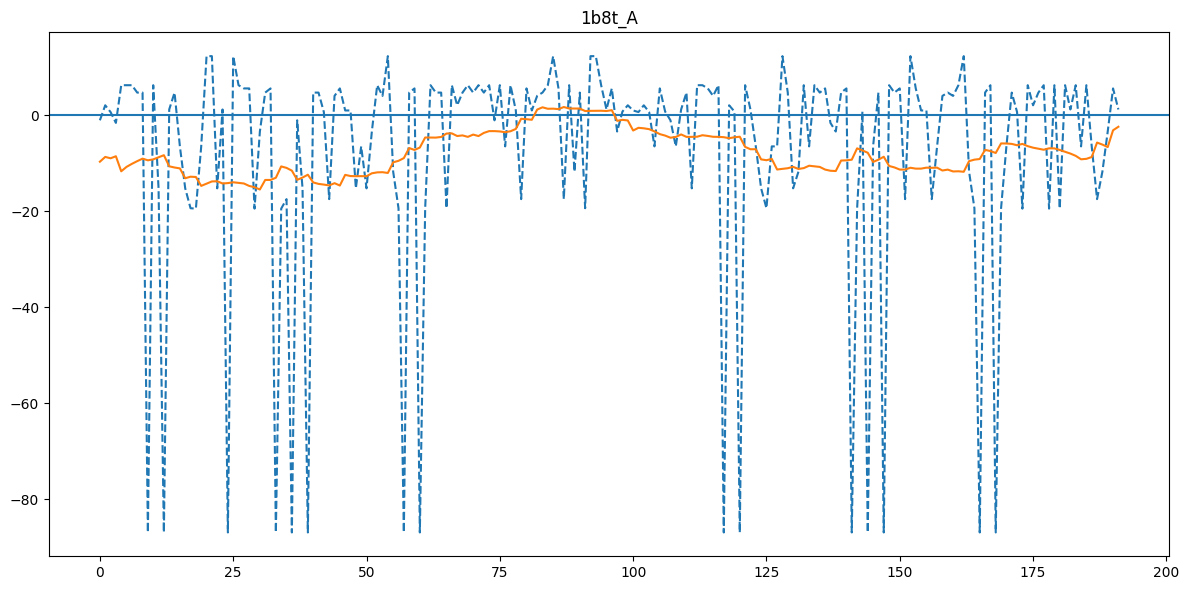

In [ ]:
# IUPRED prediction
pdb_ids =  [(pdb_id, 'A')]


pdbl = PDBList()
for pdb_id, chain_id in pdb_ids:

  pdbl.retrieve_pdb_file(pdb_id, pdir=PATH + "/pdb", file_format='pdb')
  structure = PDBParser(QUIET=True).get_structure(pdb_id, PATH + "/pdb/pdb{}.ent".format(pdb_id))
  residues = [residue for residue in structure[0][chain_id] if residue.id[0] == " "]
  seq = "".join([seq1(residue.get_resname()) for residue in residues])
  print(pdb_id, chain_id, seq)


  # Generate the prediction
  interaction = interactions_residues(seq, contact_map)
  pred_contact, pred_smooth_contact = iupred_contact(seq, interaction, 2, 100, 21)

  fig, ax = plt.subplots(figsize=(12, 6))
  ax.set_title("{}_{}".format(pdb_id, chain_id))
  ax.axhline()
  ax.plot(np.arange(len(seq)), pred_contact, ls='--')
  ax.plot(np.arange(len(seq)), pred_smooth_contact, ls='-')
  plt.tight_layout()  # Remove figure padding
  plt.savefig('./img/iupred_{}_{}.png'.format(pdb_id, chain_id), dpi=300, bbox_inches='tight')

# Q3
Calculate the estimated energy of each residue based on the weighted contribution of the frequency of neighboring amino acids in the sequence and plot the raw and smoothed energy for each residue on the same figure. Use the P matrix to calculate the estimated energy. Neighboring residues are those 2-100 residues apart from the current position.


In [ ]:
def iupred_estimated(seq, sequence_separation=2, window_size=100, window_size_smooth=10):
    '''
    Calculate residue IUPRED energy considering neighbouring residues (windows_size) and
    smoothing by window_size_smooth
    :param seq: a string of aminoacids
    :param sequence_separation: neighbours min distance
    :param window_size: neighbours max distance
    :param window_size_smooth: sliding average window size
    :return: row prediction, smoothed prediction
    '''

    pred = []  # Calculated energy per sequence position
    pred_smooth = []

    indices = [aa_list.index(aa) for aa in list(seq)]  # Transform sequence into indexes as in the P matrix

    for i, aa_index in enumerate(indices):

        # Get the slice i-100/i+100 excluding adjacent positions (+/-1)
        start_before = max(0, i - window_size)
        end_before = max(0, i - sequence_separation)
        start_after = min(len(indices) - 1, i + sequence_separation)
        end_after = min(len(indices) - 1, i + window_size)
        indices_local = indices[start_before: end_before] + indices[start_after: end_after]
        print(i, aa_index, aa_list[aa_index], len(indices), len(indices_local), start_before, end_before, start_after, end_after)

        # Count the different amino acids in the window
        row = np.full((20,), 0)
        for index in indices_local:
            row[index] += 1
        print(row)

        # calculate AA frequency
        row = row / len(indices_local)
        print(row)

        # calculate energy
        row = row * p_matrix[aa_index, ]
        print(row)

        aa_energy = np.sum(row)
        print(i, seq[i], aa_energy)

        pred.append(aa_energy)

    # Smooth the prediction (moving average)
    for i in range(len(pred)):
        frag = pred[max(0, i - window_size_smooth): min(i + window_size_smooth, len(pred))]
        pred_smooth.append(sum(frag) / len(frag))

    return pred, pred_smooth

Structure exists: './pdb//pdb\pdb1b8t.ent' 
1b8t A MPNWGGGKKCGVCQKAVYFAEEVQCEGSSFHKSCFLCMVCKKNLDSTTVAVHGDEIYCKSCYGKKYGPKGKGKGMGAGTLSTDKGESLGIKYEEGQSHRPTNPNASRMAQKVGGSDGCPRCGQAVYAAEKVIGAGKSWHKSCFRCAKCGKSLESTTLADKDGEIYCKGCYAKNFGPKGFGFGQGAGALIHSQ
0 10 M 192 98 0 0 2 100
[ 4  8  3  7  3 16  3  2 14  4  2  2  2  3  1  8  4  6  1  5]
[0.04081633 0.08163265 0.03061224 0.07142857 0.03061224 0.16326531
 0.03061224 0.02040816 0.14285714 0.04081633 0.02040816 0.02040816
 0.02040816 0.03061224 0.01020408 0.08163265 0.04081633 0.06122449
 0.01020408 0.05102041]
[-0.08489796  0.11673469  0.01867347  0.18071429 -0.16346939 -0.08489796
 -0.02295918 -0.07387755  0.23       -0.11755102 -0.13244898  0.00428571
  0.01530612  0.05816327  0.02132653  0.11346939  0.02571429 -0.15857143
 -0.07020408 -0.49642857]
0 M -0.6209183673469388
1 12 P 192 98 0 0 3 101
[ 4  8  3  7  3 16  3  2 14  4  2  1  2  3  1  8  5  6  1  5]
[0.04081633 0.08163265 0.03061224 0.07142857 0.03061224 0.16326531
 0.03061224 0.02040816 

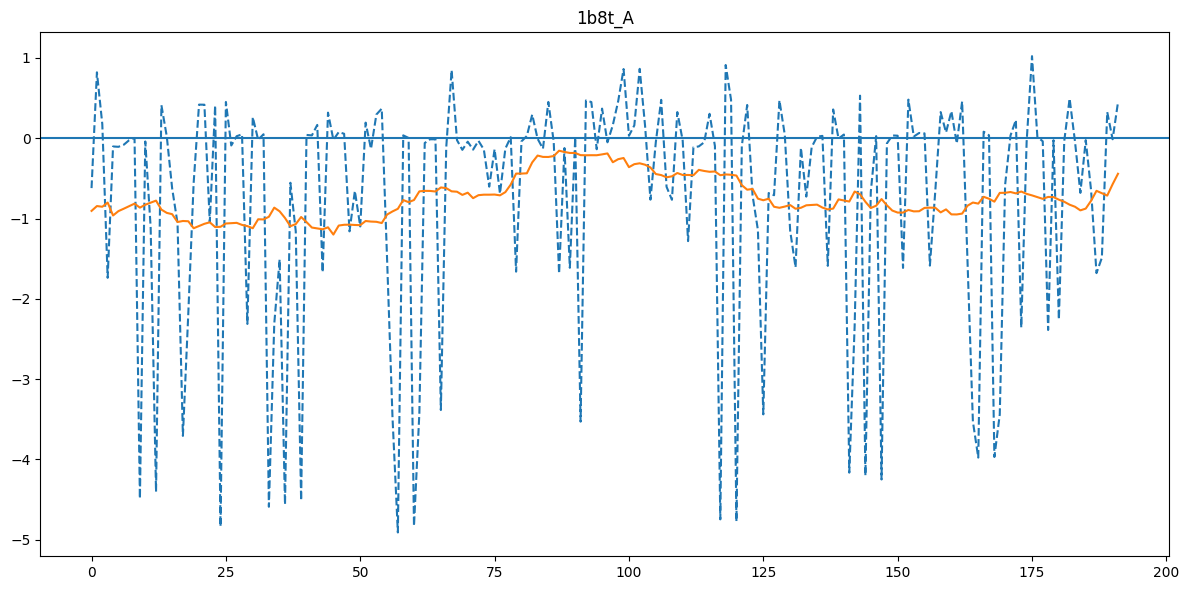

In [ ]:
# IUPRED prediction
pdb_ids =  [(pdb_id, 'A')]


pdbl = PDBList()
for pdb_id, chain_id in pdb_ids:

  pdbl.retrieve_pdb_file(pdb_id, pdir=PATH + "/pdb", file_format='pdb')
  structure = PDBParser(QUIET=True).get_structure(pdb_id, PATH + "/pdb/pdb{}.ent".format(pdb_id))
  residues = [residue for residue in structure[0][chain_id] if residue.id[0] == " "]
  seq = "".join([seq1(residue.get_resname()) for residue in residues])
  print(pdb_id, chain_id, seq)

  # Generate the prediction
  pred_estimated, pred_smooth_estimated = iupred_estimated(seq, 2, 100, 21)

  fig, ax = plt.subplots(figsize=(12, 6))
  ax.set_title("{}_{}".format(pdb_id, chain_id))
  ax.axhline()
  ax.plot(np.arange(len(seq)), pred_estimated, ls='--')
  ax.plot(np.arange(len(seq)), pred_smooth_estimated, ls='-')
  plt.tight_layout()  # Remove figure padding
  plt.savefig('./img/iupred_{}_{}.png'.format(pdb_id, chain_id), dpi=300, bbox_inches='tight')

# Q4
Report the disorder content for the two different calculations. Disorder content can be calculated as the fraction of residues with positive energy (≥ 0) over the length of the sequence. Please report both the fraction and the raw count of residues with positive energy.


In [ ]:
positive_energy_count = sum(energy >= 0 for energy in pred_contact)
print(positive_energy_count)
disorder_fraction_pred_contact = positive_energy_count / len(pred_contact)
disorder_fraction_pred_contact


115


0.5989583333333334

In [ ]:
positive_energy_count = sum(energy >= 0 for energy in pred_smooth_contact)
print(positive_energy_count)
disorder_fraction_pred_smooth_contact = positive_energy_count / len(pred_smooth_contact)
disorder_fraction_pred_smooth_contact


15


0.078125

In [ ]:
positive_energy_count = sum(energy >= 0 for energy in pred_estimated)
print(positive_energy_count)
disorder_fraction_pred_estimated = positive_energy_count / len(pred_estimated)
disorder_fraction_pred_estimated


73


0.3802083333333333

In [ ]:
positive_energy_count = sum(energy >= 0 for energy in pred_smooth_estimated)
print(positive_energy_count)
disorder_fraction_pred_smooth_estimated = positive_energy_count / len(pred_smooth_estimated)
disorder_fraction_pred_smooth_estimated

0


0.0